# Stochastic Gradient Descent with Learning Rate Schedules and Regularization

## Imports

In [7]:
from src.helpers import *

## Benchmarks of SGD

Parameters - , 


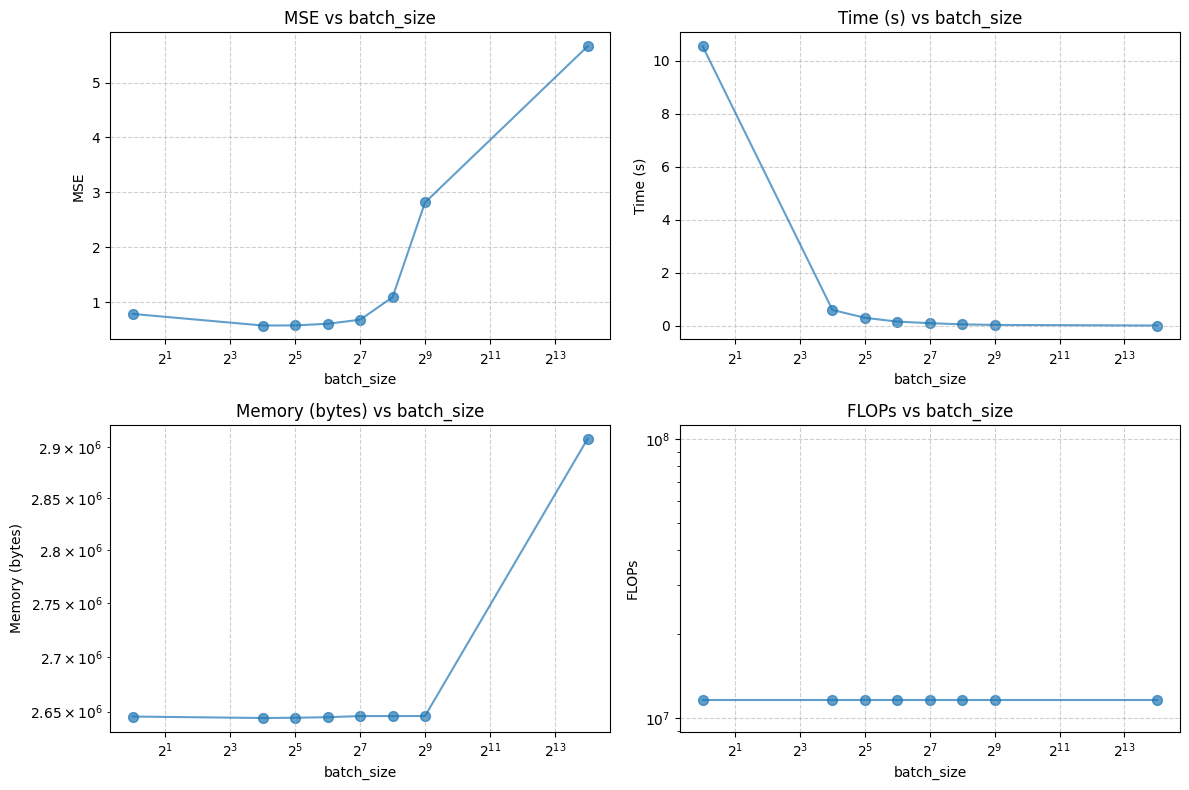

Parameters - reg: l1, 


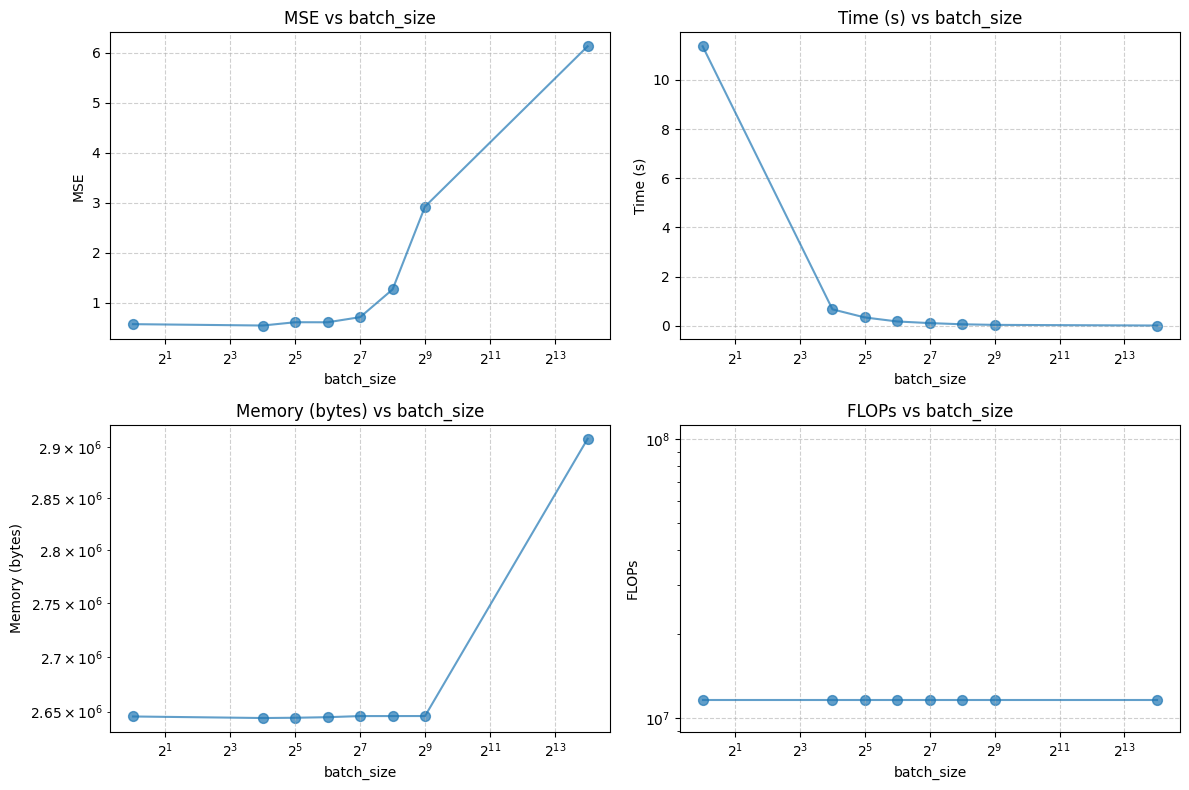

Parameters - reg: l2, 


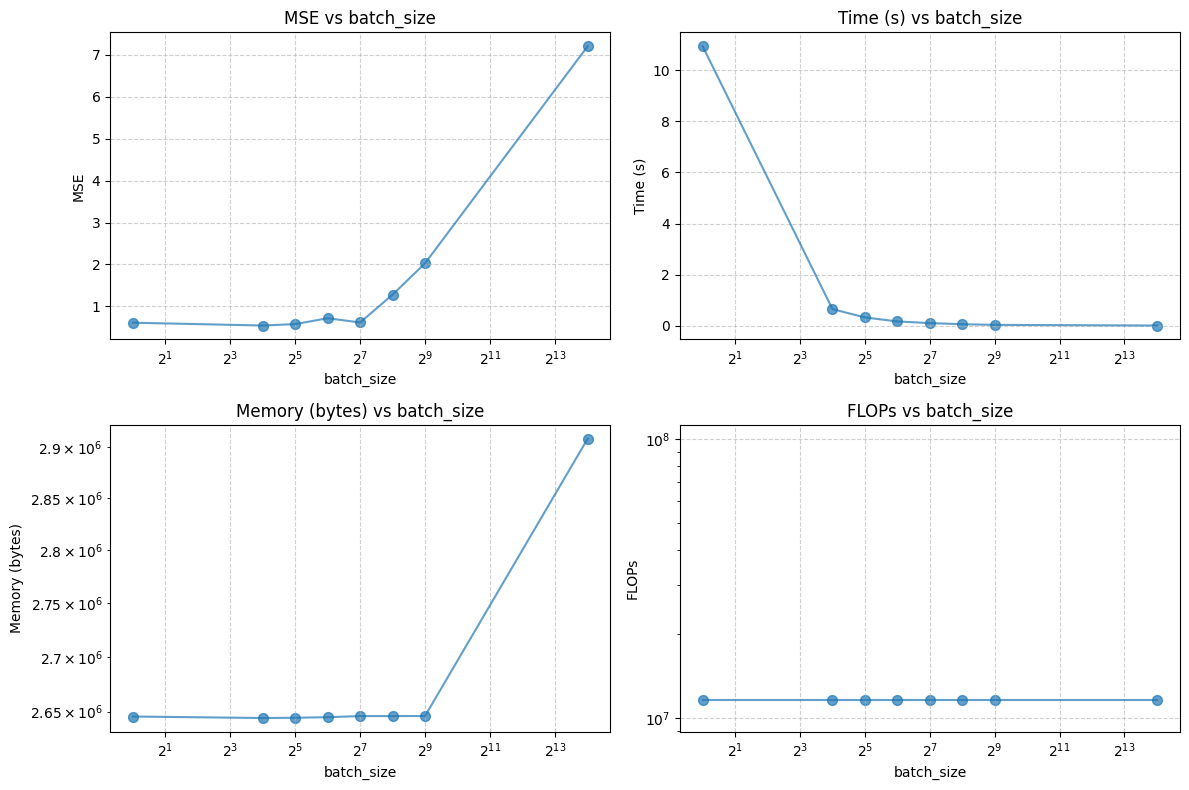

Parameters - reg: elasticnet, 


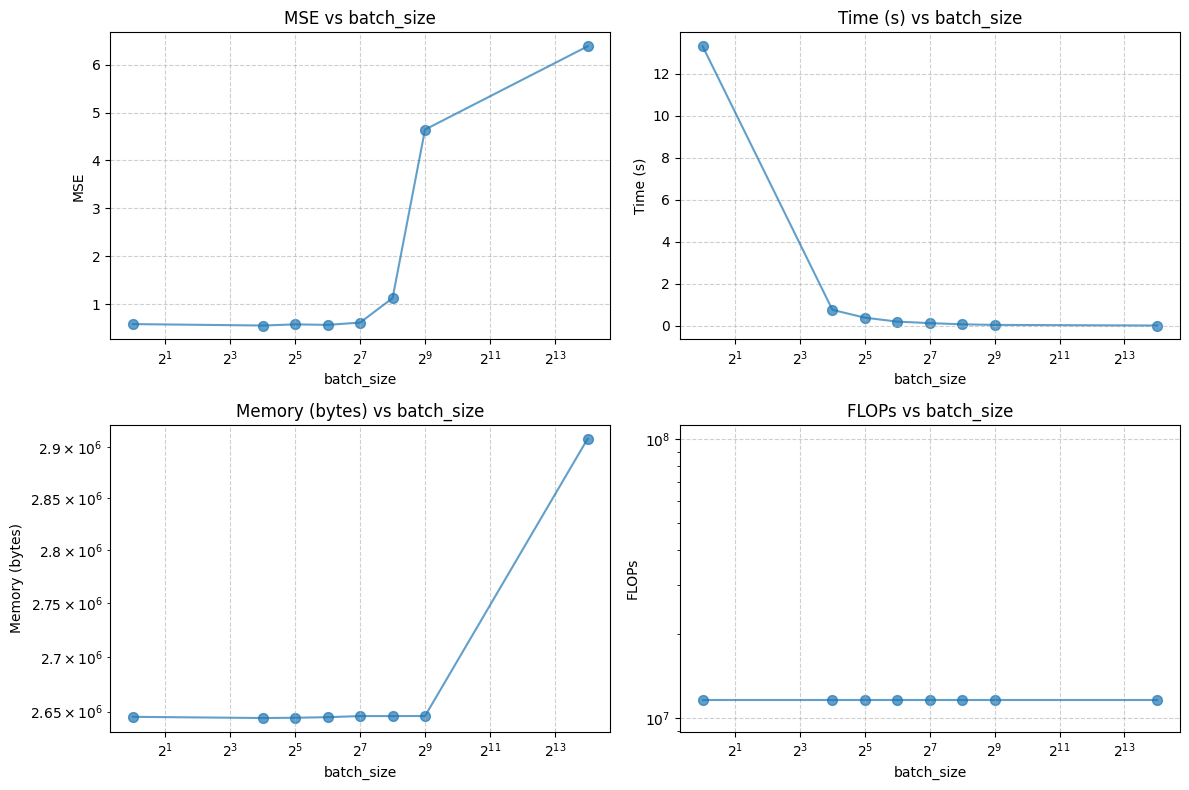

Parameters - , lrs: constant


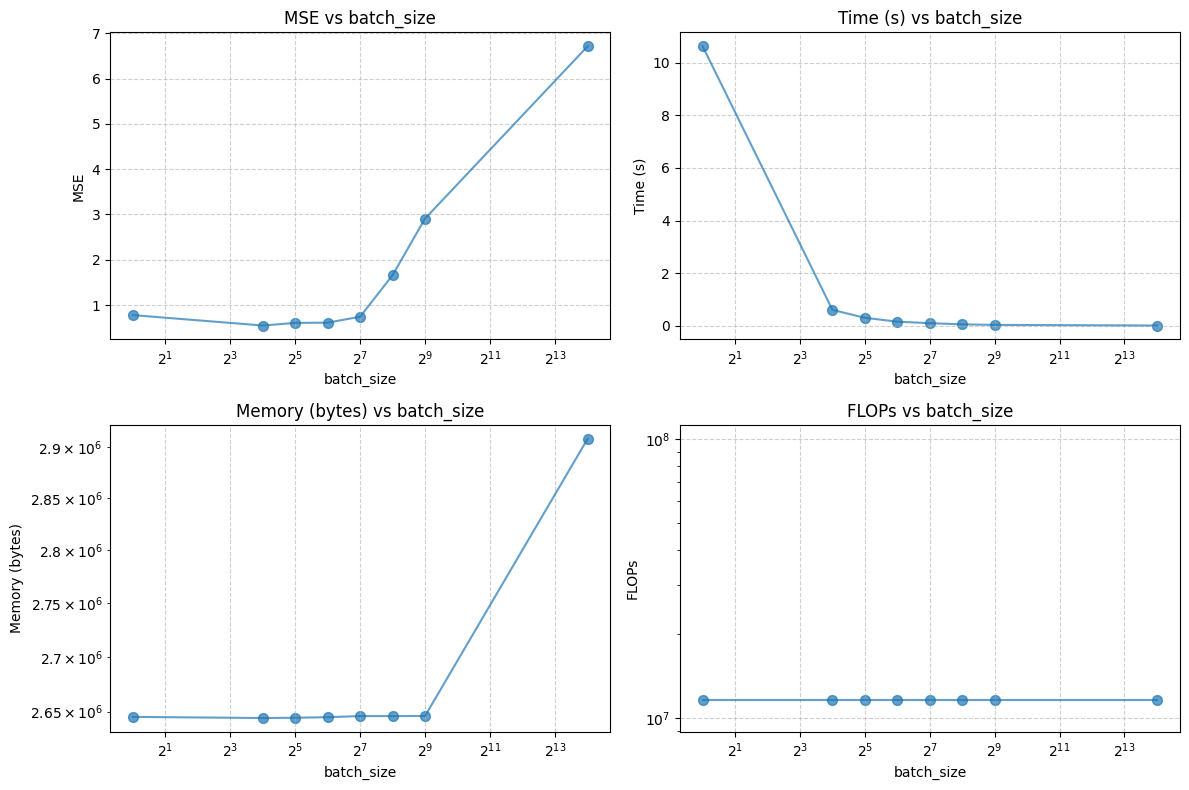

Parameters - , lrs: time_decay


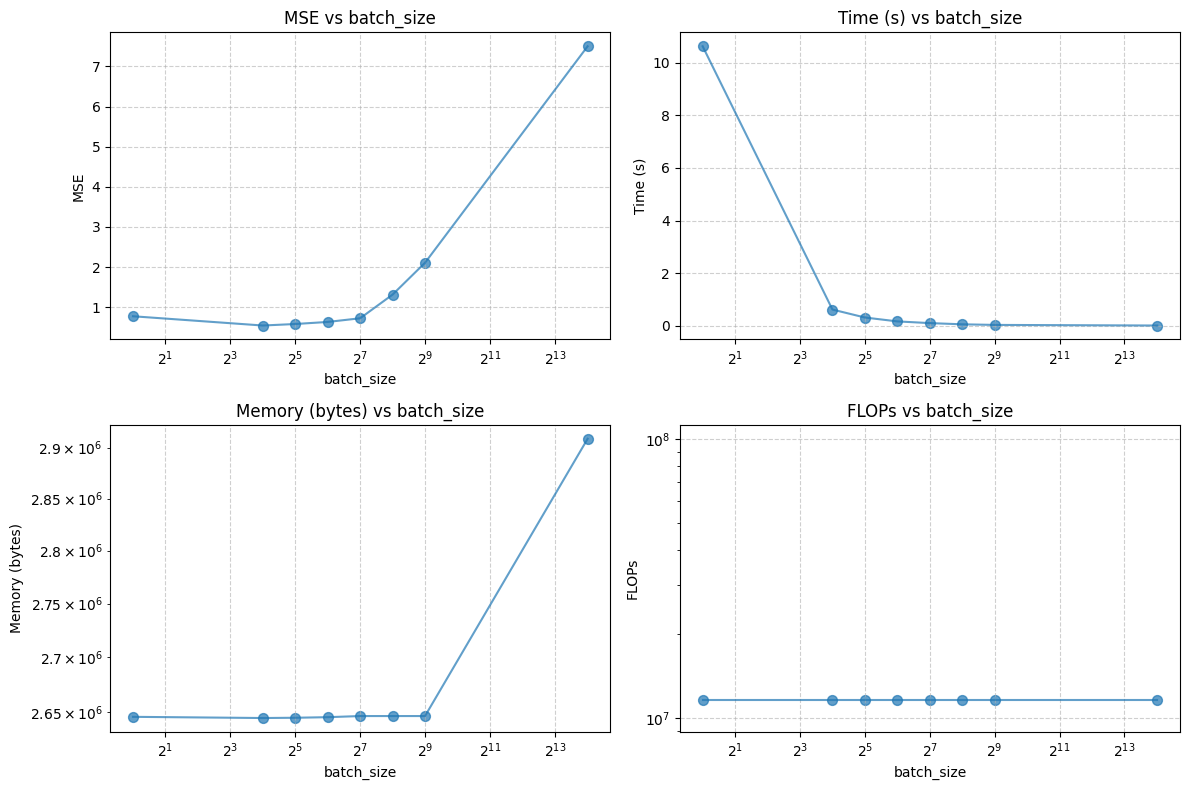

Parameters - , lrs: step_decay


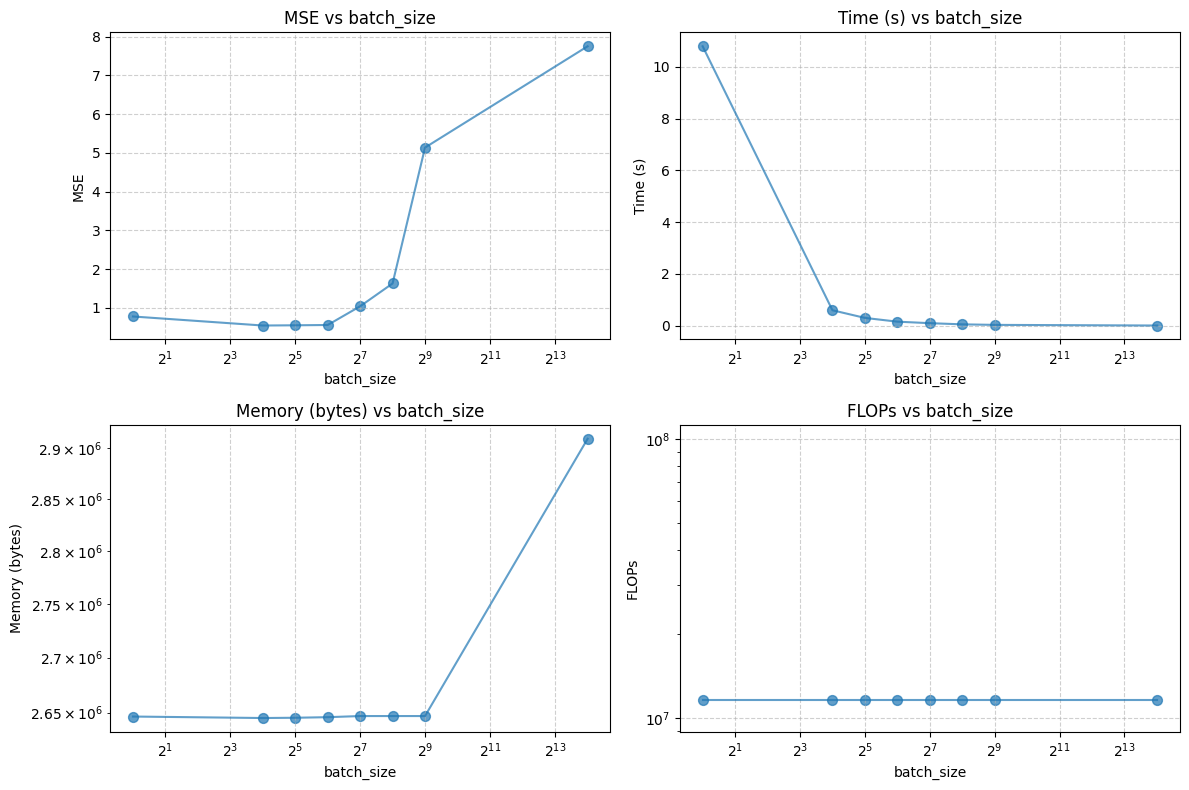

Parameters - , lrs: exponential


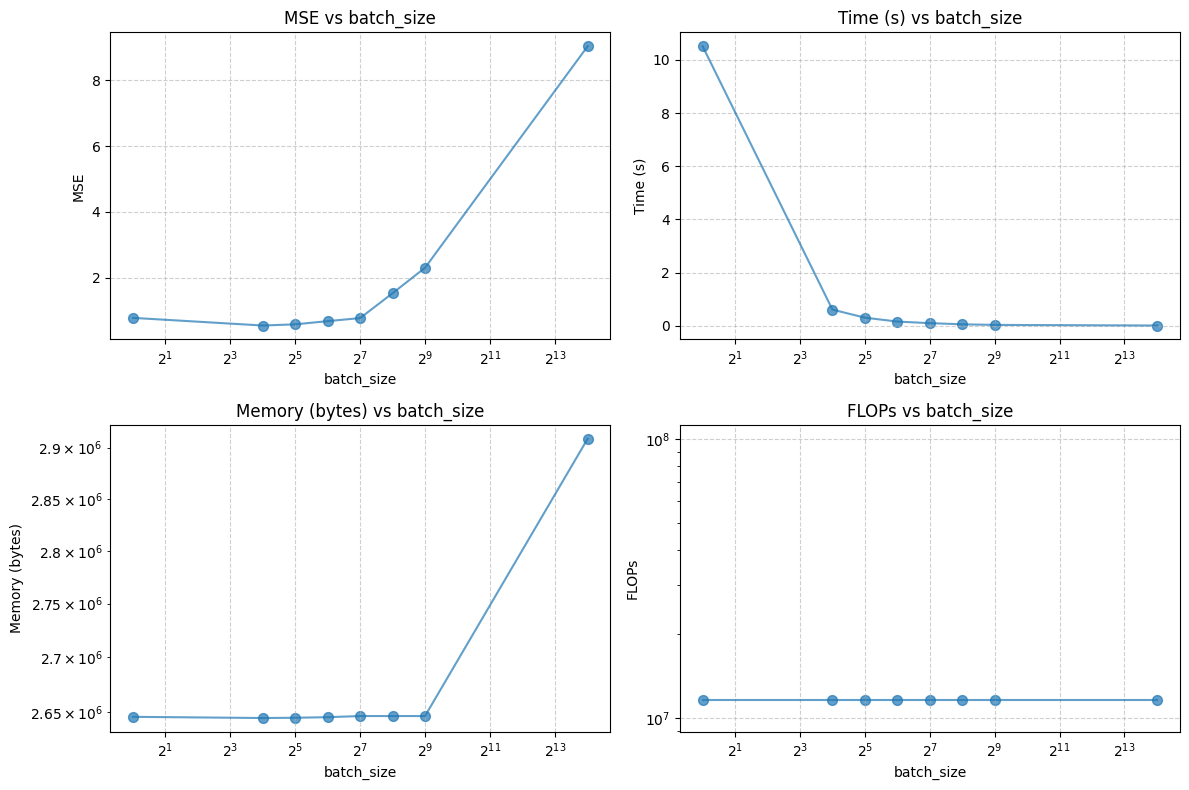

In [8]:
def bench(reg, lrs):
    models = []
    x, y = load_california(scale=True)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    for bs in [1, 16, 32, 64, 128, 256, 512, x_train.shape[0]]:
        x, y = load_california(scale=True)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        model = SGD(
            batch_size=bs,
            regularization=reg,
            lr_schedule=lrs
        )

        model.fit(x_train, y_train)
        models.append(model)

    plot_performance_metrics(models)


for reg in [None, 'l1', 'l2', 'elasticnet']:
    bench(reg, None)

for lrs in ['constant', 'time_decay', 'step_decay', 'exponential']:
    bench(None, lrs)